In [45]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [46]:
# import library
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
# from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [47]:
# Read data
train_data = 'dataset/train'
print(os.listdir(train_data))

['fire', 'not_fire']


In [48]:
# Membagi data menjadi 2 class
train_fire = os.listdir(os.path.join(train_data,'fire'))
print(len(train_fire))
train_not_fire = os.listdir(os.path.join(train_data,'not_fire'))
print(len(train_not_fire))

300
300


# Viewing the Images

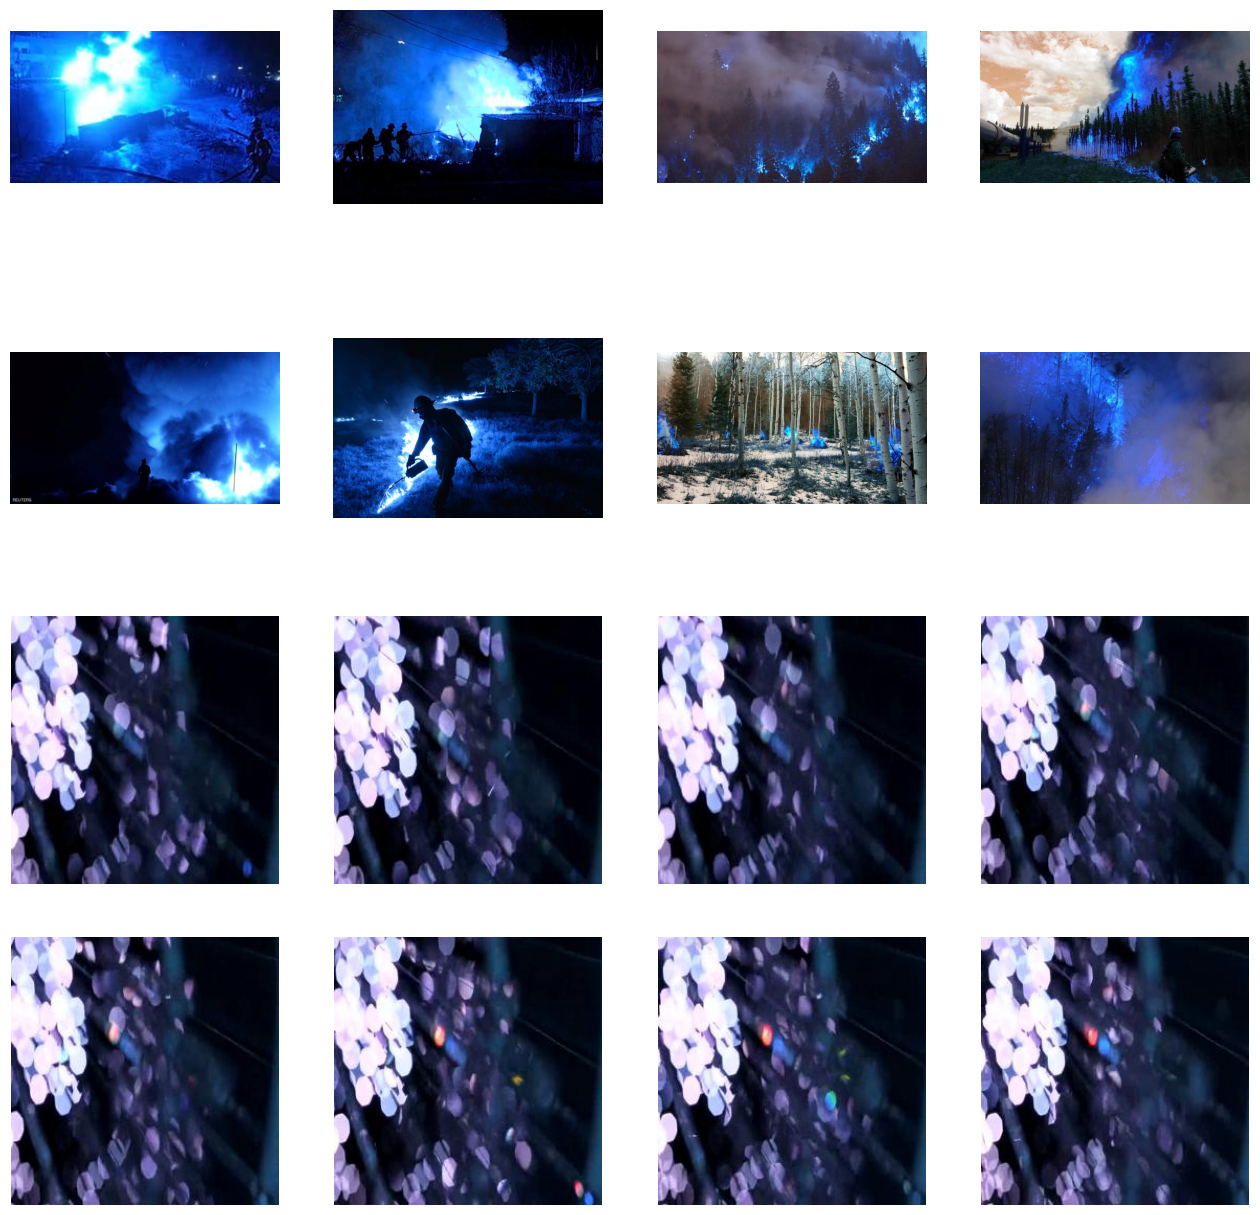

In [49]:
# Jumlah gambar yang akan ditampilkan 4 baris 4 kolom
n_rows = 4
n_cols = 4

fig = plt.gcf()

# Size gambar
fig.set_size_inches(n_rows*4,n_cols*4)

fig_index=0
fig_index+=8

# Menampilkan 8 gambar pada masing-masing class
fire_8 = [os.path.join(train_data,'fire',fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data,'not_fire',fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Print image
for i,img_path in enumerate(fire_8+not_fire_8):
    sp = plt.subplot(n_rows,n_cols,i+1)
    sp.axis('Off')
    img = cv2.imread(img_path)
    plt.imshow(img)
plt.show()

# Image pre-processing

In [57]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2
)

train_set = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='training',
)

validation_set = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='validation'
)

Found 480 images belonging to 2 classes.


Found 120 images belonging to 2 classes.


# Building the Model

In [ ]:
# use pretrained model resnet 50
pretrained_resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    classes=100,
    input_shape=(224, 224, 3)
)

# Freeze initial layers
for layer in pretrained_resnet_50.layers[:39]:
    layer.trainable = False

print(pretrained_resnet_50.output_shape)

(None, 7, 7, 2048)


In [59]:
# Model
# model = Sequential()
# model.add(pretrained_resnet_50)
# model.add(Dense(2048,activation='relu'))
# model.add(Dense(4096,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8000,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4000,activation='relu'))
# model.add(Dense(2000,activation='relu'))
# model.add(Dense(1000,activation='relu'))
# model.add(Dense(500,activation='relu'))
# model.add(Dense(250,activation='relu'))
# model.add(Dense(100,activation='relu'))
# model.add(Dense(1,activation = 'sigmoid'))

model = Sequential([
    pretrained_resnet_50,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),
    Dense(4096, activation='relu'),
    Dropout(0.2),
    Dense(8000, activation='relu'),
    Dropout(0.5),
    Dense(4000, activation='relu'),
    Dense(2000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(500, activation='relu'),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

# model.summary()

**Using callbacks and optmizers**

In [61]:
# Learning Rate
callback_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Checkpoint dengan menggunakan validation loss terkecil sebagai model terbaik
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/final_model.keras',
    monitor='val_loss',
    save_best_only=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [62]:
# Now time to train our model on fire dataset
model_hist = model.fit(
    train_set,
    validation_data = validation_set,
    epochs = 50,
    callbacks = [callback_lr, modelcheck_lr]
)

Epoch 1/50


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5067 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6938 - learning_rate: 1.0000e-08
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4884 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6921 - learning_rate: 1.1220e-08
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5001 - loss: 0.6939 - val_accuracy: 0.4833 - val_loss: 0.6955 - learning_rate: 1.2589e-08
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5108 - loss: 0.6922 - val_accuracy: 0.4917 - val_loss: 0.6938 - learning_rate: 1.4125e-08
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5234 - loss: 0.6931 - val_accuracy: 0.4833 - val_loss: 0.6947 - learning_rate: 1.5849e-08
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5059 - loss: 0.6914 - val_accuracy: 0.4833 - val_loss: 0.6938 - learning_rate: 1.7783e-08
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4869 - loss: 0.6

# Viewing the result of training

(1e-08, 0.001, 0.0, 1.0)

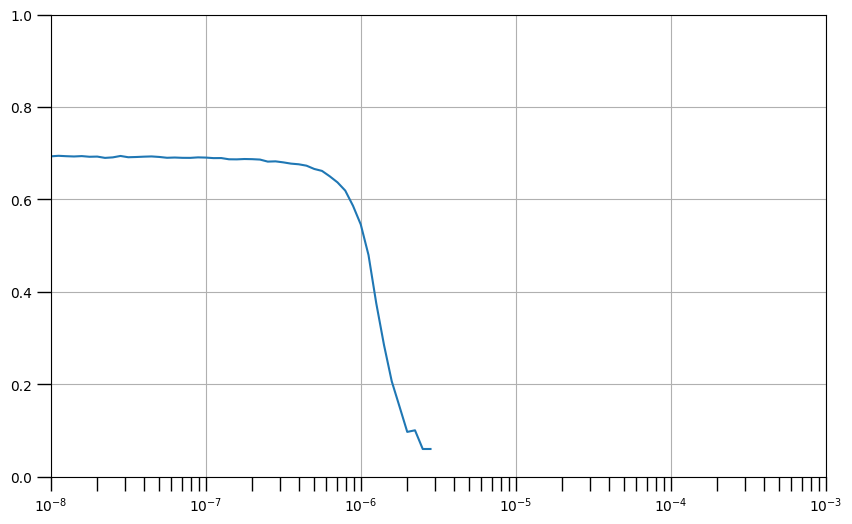

In [63]:
# Membuat graph hasil training
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, model_hist.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 1])

# Time to check our model performance

In [64]:
# Load best model
best_model = tf.keras.models.load_model('models/final_model.keras')
best_model.evaluate(validation_set)

ValueError: Layer "dense_100" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_3013>, <KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_3014>]

# Testing

In [1]:
# Setup nilai deteksi secara manual
threshold_detection = 0.65 #rata-rata nilai deteksi fire adalah >0.6
threshold_segmentation = 0.0005 #menurunkan nilai ini dapat menyebabkan api tidak terdeteksi dengan baik

In [2]:
def visualize_segmentation(model, image_path):
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    img_preprocessed = preprocess_input(img_gray)

    # mengubah dimensi gambar dari (height, width, channels) menjadi (1, height, width, channels, 1) agar sesuai dengan model
    img_input = tf.expand_dims(img_preprocessed, axis=0)
    img_input = tf.expand_dims(img_input, axis=-1)

    # prediksi segmentasi api
    prediction = (model.predict(img_input) > threshold_segmentation).astype(np.uint8)

    # ubah ke hasil prediksi ke dalam api
    binary_image = np.squeeze(prediction)
    binary_image[binary_image == 1] = 255

    # Print hasil
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(img_rgb)
    plt.subplot(233)
    plt.title('Detected Part')
    plt.imshow(binary_image, cmap='gray')

    plt.show()

In [3]:
def fire_detection(model, image_path):
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_preprocessed = preprocess_input(img_resized)

    img_input = tf.expand_dims(img_preprocessed, axis=0)

    # Prediksi
    prediction = model.predict(img_input)
    fire_probability = prediction[0][0]

    return fire_probability

In [4]:
def detect(image):

  # load model fire detection
  detection_model = best_model

  # Load model U-Net segmentation 
  segmentation_model = load_model('/content/drive/MyDrive/Semester_4/PKAC/CV_Fire/unet_model/model.hdf5')

  # prediksi api dengan model fire detection
  fire_probability = fire_detection(detection_model, image)

  class_names = ['Not-Fire', 'Fire']

  print("Image:", image)
  if fire_probability > threshold_detection:
      print("Fire detected. Performing segmentation...")
      visualize_segmentation(segmentation_model, image)
  else:
      black_img = np.zeros((256, 256), dtype=np.uint8)  # Create a black image of desired size      
      img_color = cv2.imread(image)
      img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

      plt.figure(figsize=(16, 8))
      plt.subplot(231)
      plt.title('Testing Image')
      plt.imshow(img_rgb)
      plt.subplot(233)
      plt.title('Tidak Terdeteksi')
      plt.imshow(black_img, cmap='gray')

      plt.show()

1/1 [==============================] - 0s 34ms/step
Image: /content/pexels-photo-2033933.jpeg
Fire detected. Performing segmentation...
1/1 [==============================] - 1s 563ms/step


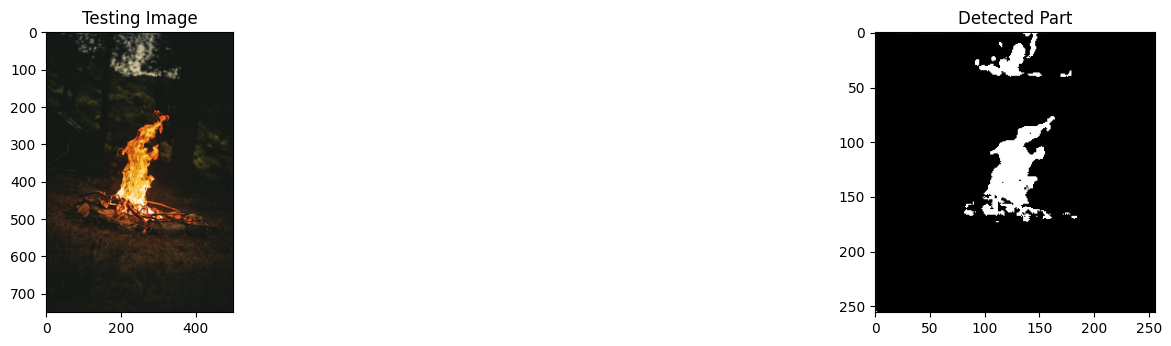

In [ ]:
detect('/content/photo-1517594422361-5eeb8ae275a9.jpeg')

In [ ]:
detect('/content/sapi1.jpg')

1/1 [==============================] - 0s 24ms/step
Image: /content/sapi1.jpg
No fire detected. Can't perform Detection.
